# Protein Embedding Analysis Pipeline

This notebook demonstrates how to fetch protein data, calculate embeddings, and visualize protein relationships using t-SNE.

This notebook demonstrates an end-to-end pipeline for protein embedding analysis. Here, we connect to a Neo4j database to fetch protein sequences from the NCBI protein database, compute high-dimensional embeddings using a pre-trained model, and then project these embeddings into two dimensions using t-SNE. The final visualization provides insights into the relationships among proteins based on their sequence properties.

In [1]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
from loguru import logger

from pyeed import Pyeed
from pyeed.analysis.embedding_analysis import EmbeddingTool

logger.remove()
level = logger.add(sys.stderr, level="INFO")

/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Database Connection and Setup
Now we'll connect to our Neo4j database and prepare it for new data by:
1. Establishing a connection
2. Wiping any existing data
3. Removing old constraints

In [2]:
uri = "bolt://129.69.129.130:7687"
user = "neo4j"
password = "12345678"

eedb = Pyeed(uri, user=user, password=password)
eedb.db.wipe_database(date='2025-03-26')

📡 Connected to database.
All data has been wiped from the database.


In [3]:
et = EmbeddingTool()

### Fetching Protein Data
We'll now fetch protein sequences from the NCBI protein database using a list of protein IDs.

In [4]:
# these are example ids
df = pd.read_csv("resources/data_example.csv", delimiter=";")
print("The data has the following columns:")
print(df.columns)

# create a dict with protein_id_database as key and phenotype as value
dict_data = dict(zip(df["protein_id_database"], df["phenotype"]))

The data has the following columns:
Index(['protein_name', 'phenotype', 'protein_id', 'protein_id_database'], dtype='object')


In [5]:
# now fecth all of the proteins from the database
eedb.fetch_from_primary_db(df["protein_id_database"].tolist(), db="ncbi_protein")

2025-03-26 11:37:31.838 | INFO     | pyeed.main:fetch_from_primary_db:87 - Found 0 sequences in the database.
2025-03-26 11:37:31.839 | INFO     | pyeed.main:fetch_from_primary_db:89 - Fetching 68 sequences from ncbi_protein.
2025-03-26 11:37:31.880 | INFO     | pyeed.adapter.primary_db_adapter:execute_requests:140 - Starting requests for 7 batches.
2025-03-26 11:37:32.848 | INFO     | pyeed.adapter.ncbi_protein_mapper:add_to_db:301 - Added/updated NCBI protein AAP20891.1 in database
2025-03-26 11:37:32.891 | INFO     | pyeed.adapter.ncbi_protein_mapper:add_to_db:301 - Added/updated NCBI protein CAJ85677.1 in database
2025-03-26 11:37:32.937 | INFO     | pyeed.adapter.ncbi_protein_mapper:add_to_db:301 - Added/updated NCBI protein SAQ02853.1 in database
2025-03-26 11:37:32.957 | INFO     | pyeed.adapter.ncbi_protein_mapper:add_to_db:301 - Added/updated NCBI protein CDR98216.1 in database
2025-03-26 11:37:33.001 | INFO     | pyeed.adapter.ncbi_protein_mapper:add_to_db:301 - Added/updated

### Calculate Sequence Embeddings
Now we'll convert our protein sequences into numerical representations (embeddings) using a pre-trained model.

In [6]:
eedb.calculate_sequence_embeddings(model_name="facebook/esm2_t36_3B_UR50D")

/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/transformers/modeling_utils.py:3437: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1899: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. 

### Visualization with t-SNE
Finally, we'll project our high-dimensional embeddings into 2D space using t-SNE and create a visualization.
The resulting plot will show how proteins relate to each other in terms of their sequence properties.

In [7]:
# get the dimensions of the embeddings get one protein and then get the dimensions of the embedding
# any random protein will do
query = "MATCH (p:Protein) RETURN p.embedding LIMIT 1"
result = eedb.db.execute_read(query)
dimensions = np.array(result[0]['p.embedding']).shape
print(dimensions)


(2560,)


68


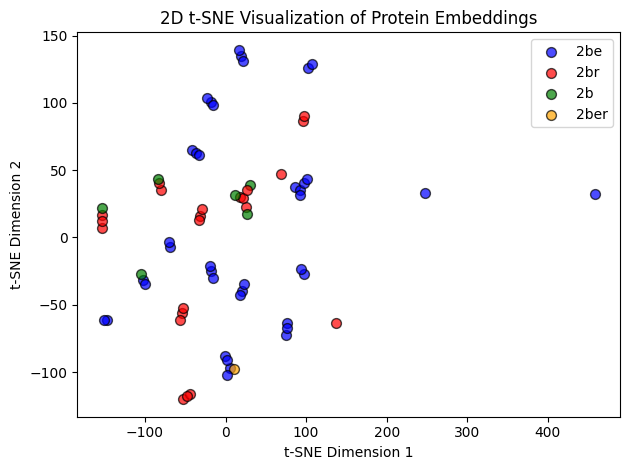

In [8]:
# get all of the data from embedding
embedding_tool = EmbeddingTool()
protein_ids, embeddings_2d, labels, colors = (
    embedding_tool.calculate_2d_projection_tsne(
        db=eedb.db,
        ids_list=df["protein_id_database"].tolist(),
        perplexity=1,
        n_iter=3000,
        ids_list_labels=dict_data,
    )
)
print(len(protein_ids))

labels_already_plotted = []

# create a scatter plot for each unique label
for i in range(len(protein_ids)):
    if labels[i] not in labels_already_plotted:
        plt.scatter(
            embeddings_2d[i, 0],
            embeddings_2d[i, 1],
            alpha=0.7,
            s=50,
            edgecolor="k",
            color=colors[i],
            label=labels[i],
        )
        labels_already_plotted.append(labels[i])
    else:
        plt.scatter(
            embeddings_2d[i, 0],
            embeddings_2d[i, 1],
            alpha=0.7,
            s=50,
            edgecolor="k",
            color=colors[i],
        )
plt.title("2D t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()

### Protein Embedding Search Methods

There are two main approaches implemented for searching similar proteins using embeddings:

#### 1. Simple Search Method

The simple method (`find_closest_matches_simple`) loads all embeddings into memory to calculate distances. While straightforward, it's best suited for smaller datasets:


In [9]:
# this is the simple way to find the closest matches it loads all proteins into memory
# so this is not the best way to do this for large datasets
# on very small datasets it is still fine though, and works easily

results = et.find_closest_matches_simple(
    start_sequence_id=df["protein_id_database"].tolist()[0],
    db=eedb.db,
    metric="cosine",
    n=10,
)

print(f"Resulst for index {df['protein_id_database'].tolist()[0]} are:")
print(results)

Resulst for index AAP20891.1 are:
[('AAP20891.1', 0.0), ('ADL13944.1', 1.2696941380951898e-05), ('AGQ50511.1', 2.3084859425925863e-05), ('CBX53726.1', 2.3443578533011156e-05), ('AAL29433.1', 3.0809776502382924e-05), ('CAA76796.1', 3.2400445545976986e-05), ('CAC67290.1', 4.856582147116928e-05), ('AFN21551.1', 4.953471590429803e-05), ('CAA74912.2', 5.021707417551813e-05), ('CTA52364.1', 6.113568903631794e-05)]



##### Advantages:
- Simple implementation
- Works well for small datasets
- Flexible distance metrics

##### Limitations:
- Memory intensive for large datasets
- Slower for large-scale searches
- Not scalable for production use with big databases

#### 2. Vector Index Search

The vector index method uses Neo4j's native vector indexing capabilities (HNSW algorithm) for efficient similarity search. This is the recommended approach for larger datasets and production use.

##### Setting up the Vector Index:


In [10]:
# the more complex was involes creating a vector index of the embeddings
# the vector index math and implementation is provied by neo4j

# here we drop the vector index
et.drop_vector_index(
    db=eedb.db,
    index_name="vector_index_Protein_embedding",
)
# here we create the vector index
et.create_embedding_vector_index_neo4j(
    db=eedb.db,
    index_name="vector_index_Protein_embedding",
    similarity_function="cosine",
    dimensions=960,
    m=16,
    ef_construction=512,
)


##### Parameters Explained:

- `dimensions`: The size of your embedding vectors
  - Use 960 for ESM-C model
  - Use 1280 for ESM-2 model

- `m` (default=16): Maximum number of connections per node in the HNSW graph
  - Higher values = better accuracy but slower indexing
  - Lower values = faster indexing but potentially less accurate
  - Recommended range: 5-100

- `ef_construction` (default=512): Controls index quality during construction
  - Higher values = better quality but slower indexing
  - Lower values = faster indexing but potentially lower quality
  - Recommended range: 100-1000

##### Searching with the Vector Index:


In [11]:
# here we use the vector index to find the closest matches
results = et.find_nearest_neighbors_based_on_vector_index(
    db=eedb.db,
    query_protein_id=df["protein_id_database"].tolist()[0],
    index_name="vector_index_Protein_embedding",
    number_of_neighbors=10,
)

print(results)

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `db.index.vector.queryNodes`: Caused by: java.lang.IllegalArgumentException: Index query vector has 2560 dimensions, but indexed vectors have 960.}


##### Advantages of Vector Index:
- Highly efficient for large datasets
- Optimized for high-dimensional data
- Scales well with database size
- Maintains good performance with growing data

##### Important Notes:

1. The vector index needs time to populate after creation. The code automatically waits and shows a progress bar during population.

2. The similarity scores returned by the vector index search are:
   - For cosine similarity: Range [-1 to 1], where 1 is most similar
   - For euclidean similarity: Lower values indicate more similarity

3. The index is persistent in the database and only needs to be created once, unless you want to change its parameters.

4. Memory usage is optimized as the index handles the heavy lifting instead of loading all embeddings into memory.

For most production use cases, the vector index method is recommended as it provides the best balance of performance and scalability.